In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Verbatims - ULMFiT Sentiment (multi-label classification)

> Experiments related to building a multi-label classification model for survey comments captured in the Tritonlytics survey delivery system

In [3]:
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

Prepare the data source

In [11]:
train_df = pd.read_csv(SENTIMENT_CLS_PATH/'train.csv')
valid_df = pd.read_csv(SENTIMENT_CLS_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [12]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [13]:
train_df.feels_threatened.value_counts()

0    14032
1      353
Name: feels_threatened, dtype: int64

In [14]:
valid_df.feels_threatened.value_counts()

0    1558
1      43
Name: feels_threatened, dtype: int64

In [15]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + SENT_LABELS[1:]].head()

,labels,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense
0,is_negative,0,0,0,1,0,0,0,0
1,is_negative,0,0,0,1,0,0,0,0
2,is_positive,0,1,0,0,0,0,0,0
3,is_positive,0,1,0,0,0,0,0,0
4,is_negative,0,0,0,1,0,0,0,0


In [16]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [17]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the low-level `Datasets` API

In [18]:
%%time

x_tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(vocab=vocab)
]

# y_tfms = [ 
#     ColReader('labels', label_delim=' '),
#     MultiCategorize(vocab=SENT_LABELS[1:], add_na=False),
#     OneHotEncode()
# ]


y_tfms = [ 
    ColReader(SENT_LABELS[1:]),
    EncodedMultiCategorize(vocab=SENT_LABELS[1:]),
]

dsets = Datasets(items=df,
                 tfms=[x_tfms, y_tfms], 
                 splits=ColSplitter(col='is_valid')(df), 
                 dl_type=SortedDL)

len(dsets.train), len(dsets.valid)

CPU times: user 849 ms, sys: 273 ms, total: 1.12 s
Wall time: 1.73 s


(14385, 1601)

In [19]:
%%time
dls = dsets.dataloaders(bs=bsz, seq_len=bptt, before_batch=pad_input_chunk)

CPU times: user 13.6 s, sys: 981 ms, total: 14.5 s
Wall time: 14.6 s


In [20]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (8 items)


In [21]:
print(dls.train_ds[21])

(TensorText([   2,    8,  242,   16,    7,   99, 4707,    9,    8,   20,  118,   39,
        1117,   55,   11,  111,   20,    9,    8,  179,   11,  595,    9]), TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0.]))


In [22]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj so another survey has come around and i anticipate it will have the same effect as all the other surveys … basically nothing will change , or should i say any changes will not be for the good of the staff . xxmaj this years rant will consist of two items . xxmaj first lets discuss the xxunk issue of lack of pay . xxmaj we all know that working for a xxmaj university results in a paycheck 15 to 20 % less than typical outside jobs of the same type but right now i know of people that are 20 to 30 % under the going rate while we sit and watch upper echelon employees get anywhere from $ 2 xxrep 3 0 to over $ 50 , xxrep 3 0 dollars pay raises since 2008 . xxmaj we are still trying to figure out how some",is_very_negative;is_negative;feels_threatened
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_very_negative;is_negative;feels_threatened


In [23]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 920]) torch.cuda.LongTensor torch.Size([80, 8]) torch.cuda.FloatTensor 80


In [24]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

'xxbos xxmaj so another survey has come around and i anticipate it will have the same effect as all the other surveys … basically nothing will change , or should i say any changes will not be for the good of the staff . xxmaj this years rant will consist of two items . xxmaj first lets discuss the xxunk issue of lack of pay . xxmaj we all know that working for a xxmaj university results in a paycheck 15 to 20 % less than typical outside jobs of the same type but right now i know of people that are 20 to 30 % under the going rate while we sit and watch upper echelon employees get anywhere from $ 2 xxrep 3 0 to over $ 50 , xxrep 3 0 dollars pay raises since 2008 . xxmaj we are still trying to figure out how some people can get $ xxunk in “ extra xxmaj pay ” . xxmaj it is understood that keeping quality people is important and pay is a very big incentive to keep these people but the message it sends is that we have plenty of money for people that already earn plenty of money but we ca nt 

Using the mid-level `DataBlocks` API

In [25]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    MultiCategoryBlock(encoded=True, vocab=SENT_LABELS[1:])
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(SENT_LABELS[1:]),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 132 ms


In [26]:
# dblock.summary(df)

In [27]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 14.1 s, sys: 734 ms, total: 14.8 s
Wall time: 15.4 s


In [28]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (8 items)


In [29]:
print(dls.train_ds[21])

(TensorText([   2,    8,  242,   16,    7,   99, 4707,    9,    8,   20,  118,   39,
        1117,   55,   11,  111,   20,    9,    8,  179,   11,  595,    9]), TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0.]))


In [30]:
dls.vocab[1]

(#8) ['is_very_positive','is_positive','is_very_negative','is_negative','is_suggestion','feels_threatened','has_profanity','is_nonsense']

In [31]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj so another survey has come around and i anticipate it will have the same effect as all the other surveys … basically nothing will change , or should i say any changes will not be for the good of the staff . xxmaj this years rant will consist of two items . xxmaj first lets discuss the xxunk issue of lack of pay . xxmaj we all know that working for a xxmaj university results in a paycheck 15 to 20 % less than typical outside jobs of the same type but right now i know of people that are 20 to 30 % under the going rate while we sit and watch upper echelon employees get anywhere from $ 2 xxrep 3 0 to over $ 50 , xxrep 3 0 dollars pay raises since 2008 . xxmaj we are still trying to figure out how some",is_very_negative;is_negative;feels_threatened
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_very_negative;is_negative;feels_threatened


In [32]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 920]) torch.cuda.LongTensor torch.Size([80, 8]) torch.cuda.FloatTensor 80


In [33]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

'xxbos xxmaj so another survey has come around and i anticipate it will have the same effect as all the other surveys … basically nothing will change , or should i say any changes will not be for the good of the staff . xxmaj this years rant will consist of two items . xxmaj first lets discuss the xxunk issue of lack of pay . xxmaj we all know that working for a xxmaj university results in a paycheck 15 to 20 % less than typical outside jobs of the same type but right now i know of people that are 20 to 30 % under the going rate while we sit and watch upper echelon employees get anywhere from $ 2 xxrep 3 0 to over $ 50 , xxrep 3 0 dollars pay raises since 2008 . xxmaj we are still trying to figure out how some people can get $ xxunk in “ extra xxmaj pay ” . xxmaj it is understood that keeping quality people is important and pay is a very big incentive to keep these people but the message it sends is that we have plenty of money for people that already earn plenty of money but we ca nt 

Save the `Dataloaders` object for future use

In [34]:
# save dataloaders
torch.save(dls, SENTIMENT_CLS_PATH/f'data_cls_sentiment.pkl')
# dls = torch.load(SENTIMENT_CLS_PATH/f'data_cls_sentiment.pkl')

## Training

Configure a forward or backwards run

In [198]:
backwards = False
m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(SENTIMENT_CLS_PATH/f'data_cls_sentiment.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))
    # 09/21/2020: fastai uses the default pad_first=True for both forward and backward
    # dls.before_batch = partial(pad_input_chunk, pad_first=not backwards)

In [199]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {SENTIMENT_CLS_PATH/'models/'}  

Configure metrics

In [200]:
# define metrics
beta, start, end, average, sample_weight = 1, 0.1, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta1_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

Configure loss function

In [201]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
pos_weight_vec

[4.734712230215828,
 1.0742705570291777,
 5.111650485436893,
 1.0,
 1.2045298558682225,
 14.91501416430595,
 27.13917525773196,
 5.02865329512894]

In [202]:
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))

Configure learner

In [203]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='fbeta_score', comp=np.greater, fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, average=average, sample_weight=sample_weight,
                                            start=start, end=end)

In [204]:
learn_cbs = []
fit_cbs = [best_model_cb, opt_thresh_cb]

learn_metrics = [ 
    accuracy_multi, fbeta1_metric, prec_metric, recall_metric, roc_auc_metric,
    # opt_th_metric, opt_fscore_metric, opt_acc_metric # => only include for testing
]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                backwards=backwards,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.5,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
#                                 loss_func=loss_func,
                                cbs=learn_cbs,
                                path=SENTIMENT_CLS_PATH)

learn.opt = learn.create_opt()

In [205]:
learn.summary()

SequentialRNN (Input shape: ['80 x 920'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           80 x 56 x 400        0          False     
________________________________________________________________
RNNDropout           80 x 56 x 1152       0          False     
________________________________________________________________
RNNDropout           80 x 56 x 1152       0          False     
________________________________________________________________
BatchNorm1d          80 x 1200            2,400      True      
________________________________________________________________
Dropout              80 x 1200            0          False     
________________________________________________________________
Linear               80 x 50              60,000     True      
________________________________________________________________
ReLU                 80 x 50              0          False     
________________________________________________________

In [206]:
# learn.show_training_loop()

In [207]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [208]:
best_model_path = SENTIMENT_CLS_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0831763744354248)

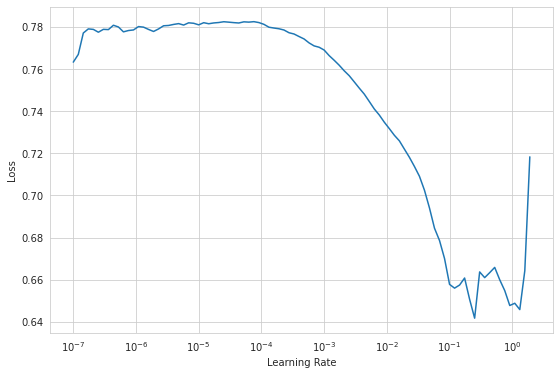

In [209]:
learn.lr_find()

In [210]:
lr= 1e-1

In [211]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.274467,0.181926,0.928482,0.761504,0.777945,0.768406,0.837809,0.370000,00:11


Better model found at epoch 0 with fbeta_score value: 0.7615044530909548.


In [212]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/sentiment/models/fwd_cls_last_ft_multilabel.pth')

In [213]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(5e-2/(2.6**4), 5e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.208020,0.158036,0.933089,0.795785,0.776169,0.827401,0.864730,0.330000,00:11


Better model found at epoch 0 with fbeta_score value: 0.7957852921860376.


In [214]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/sentiment/models/fwd_cls_last2_ft_multilabel.pth')

In [215]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lr_max=slice(1e-2/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.169915,0.149913,0.939101,0.811035,0.800015,0.828376,0.878004,0.310000,00:15


Better model found at epoch 0 with fbeta_score value: 0.8110345658539388.


In [216]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/sentiment/models/fwd_cls_last3_ft_multilabel.pth')

In [217]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(5e-3/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.150736,0.150536,0.936290,0.809757,0.774636,0.854217,0.881882,0.250000,00:18
1,0.154534,0.147256,0.941911,0.815689,0.819046,0.814725,0.875844,0.400000,00:18
2,0.129013,0.156973,0.934416,0.816555,0.765945,0.880546,0.892228,0.200000,00:19
3,0.109324,0.159487,0.940662,0.817423,0.807911,0.832277,0.880352,0.370000,00:19
4,0.100088,0.160427,0.940428,0.819334,0.805727,0.837153,0.882611,0.340000,00:18


Better model found at epoch 0 with fbeta_score value: 0.8097573053104048.
Better model found at epoch 1 with fbeta_score value: 0.815689402115931.
Better model found at epoch 2 with fbeta_score value: 0.816554882991848.
Better model found at epoch 3 with fbeta_score value: 0.8174233115339797.
Better model found at epoch 4 with fbeta_score value: 0.8193335847504892.


In [218]:
# acc=0.932074 f1=0.802432 prec=0.763539 recall=0.851292 auc=0.873737 opt_th0.250000

In [219]:
learn.loss_func.thresh

0.33999999999999986

In [220]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/sentiment/models/fwd_cls_multilabel.pth')

Export model for inference

In [221]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [222]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [223]:
learn.validate() # ... returns [loss, metrics]

(#7) [0.16042737662792206,0.940427839756012,0.8193335847504892,0.8057269752619358,0.8371526084836665,0.8826107144437774,0.33999999999999986]

In [224]:
# learn.show_results(max_n=4, trunc_at=60) #=> throws an exception right now!!!

In [225]:
interp = Interpretation.from_learner(learn)

In [226]:
interp.plot_top_losses(k=5)

,input,target,predicted,probability,loss
0,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_positive,is_suggestion,0.998570442199707,2.140632390975952
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_nonsense,is_positive,0.9856292605400085,1.7904682159423828
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_positive;is_suggestion,is_very_positive;is_positive,0.9998250603675842,1.7879786491394043
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,is_suggestion,is_positive,0.9984906911849976,1.745365858078003
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxp

Use it for inference

In [227]:
inf_learn = load_learner(SENTIMENT_CLS_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [228]:
inf_learn.loss_func.thresh

0.33999999999999986

In [229]:
inf_learn.predict('I feel very uncomfortable talking to my supervisor even though she loves dogs. Help!!!', 
                  with_input=True)

('xxbos i feel very uncomfortable talking to my supervisor even though she loves dogs . xxmaj help xxrep 3 !',
 (#2) ['is_negative','feels_threatened'],
 tensor([False, False, False,  True, False,  True, False, False]),
 tensor([7.6602e-03, 6.9726e-02, 1.4305e-01, 9.5633e-01, 2.9592e-02, 9.8709e-01,
         1.3306e-04, 6.3689e-03]))

Review final validation loss for best model

In [230]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [231]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [232]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.16042740643024445


In [233]:
learn.predict("I feel very unsafe and threatened here. I HATE my life!!!")

((#3) ['is_very_negative','is_negative','feels_threatened'],
 tensor([False, False,  True,  True, False,  True, False, False]),
 tensor([8.1978e-03, 7.4938e-03, 9.3288e-01, 9.9938e-01, 1.8893e-03, 5.9043e-01,
         1.9053e-04, 5.0017e-03]))

In [234]:
learn.dls.tfms[1].vocab

(#8) ['is_very_positive','is_positive','is_very_negative','is_negative','is_suggestion','feels_threatened','has_profanity','is_nonsense']

## Review

### Lets look at validation metrics

In [235]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs  = learn.get_preds(with_input=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(1601,
 torch.Size([1601, 8]),
 torch.Size([1601, 8]),
 1601,
 8,
 0.33999999999999986)

In [236]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [237]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.4800000000000001, 0.34, 0.08000000000000002)

In [238]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.8228305960245648, 0.8193335847504892, 0.8575935320520726)

In [239]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.8193335847504892

In [240]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9421455264091492, 0.940427839756012, 0.9112273454666138)

In [241]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.940427839756012

### Overall metrics

In [242]:
eval_targs = targs.flatten() # targs[:,0]
eval_probs = probs.flatten() # probs[:,0]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [243]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

0.6183635227982511


In [244]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

0.9404278575890068


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [245]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 10757


In [246]:
most_freq_class_count / len(eval_targs)

0.8398657089319176

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [247]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

0.7826027260372355


#### Confusion Matrix

Describes the performance of a classification model

In [248]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [249]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

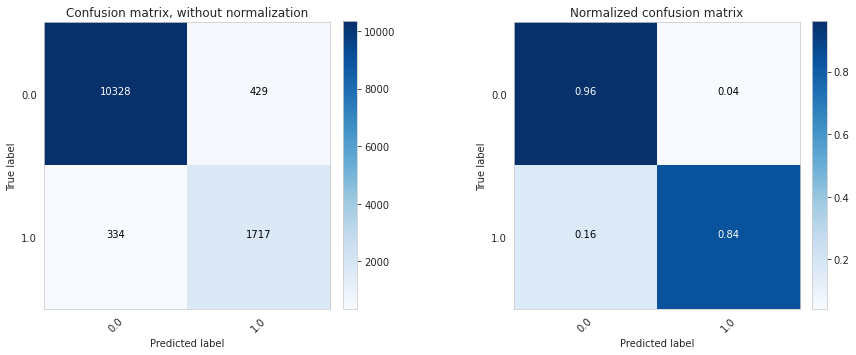

In [250]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [251]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), [0,1], 
                                sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10757
           1       0.80      0.84      0.82      2051

    accuracy                           0.94     12808
   macro avg       0.88      0.90      0.89     12808
weighted avg       0.94      0.94      0.94     12808



/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

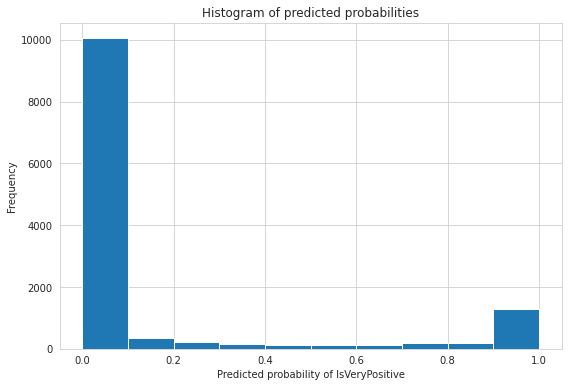

In [252]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [253]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

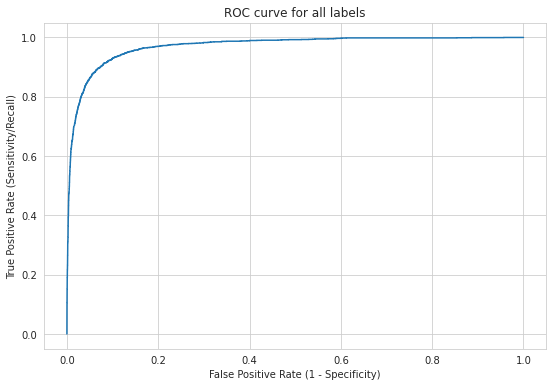

In [254]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [255]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9706942837716322


### Let's look at things by label by label

In [256]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(SENT_LABELS[1:]):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [257]:
# label_metrics

IS_VERY_POSITIVE

Null Accuracy:	0.929419113054341
AUC Score:	0.9614378152060139

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9406620861961275	0.9350405996252342	0.9063085571517802	
Cohen's Kappa:	0.5495656912365288	0.5803703741040556	0.5182914843000935	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9684              0.9677              0.9681              1488                
1                   0.5789              0.5841              0.5815              113                 
avg/total           0.7737              0.7759              0.7748              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9792              0.9503              0.9645              1488                
1                   0.5287              0.7345              0.6148              1

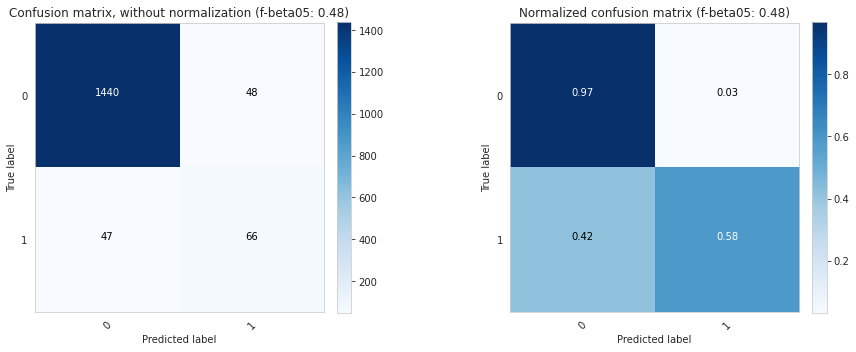

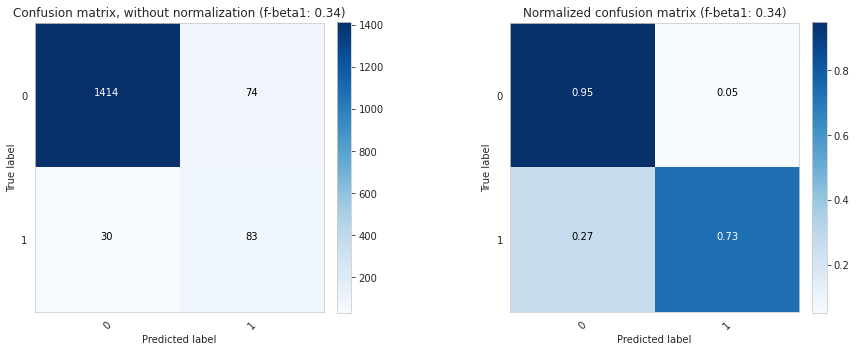

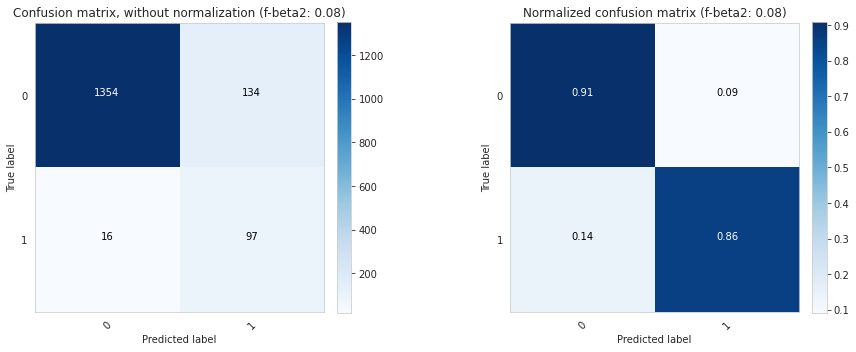



ROC Curve:


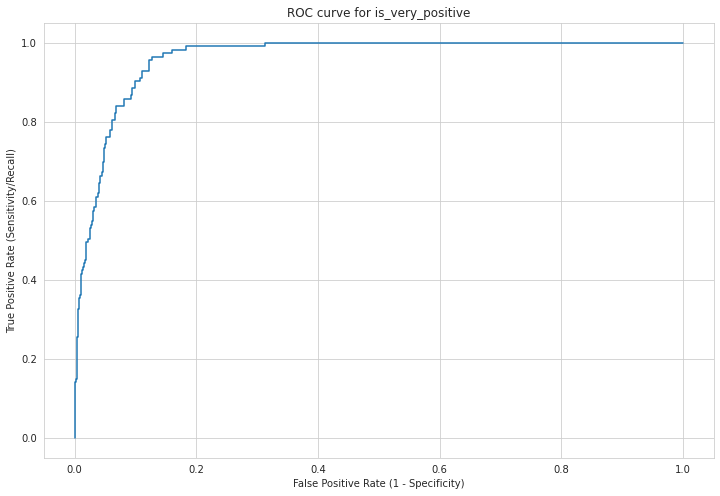

Predicted Probability Distribution:


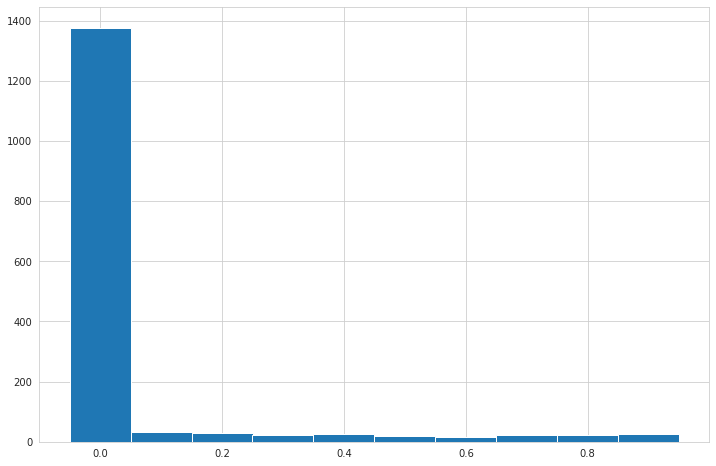



----------------------------------------------------------------------------------------------------


IS_POSITIVE

Null Accuracy:	0.6489693941286696
AUC Score:	0.9719840799564321

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9237976264834479	0.9237976264834479	0.9050593379138039	
Cohen's Kappa:	0.8324750756478959	0.8335645386686663	0.7996413580968597	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9396              0.9432              0.9414              1039                
1                   0.8943              0.8879              0.8911              562                 
avg/total           0.9169              0.9156              0.9162              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9464              0.9355              0.9409              1

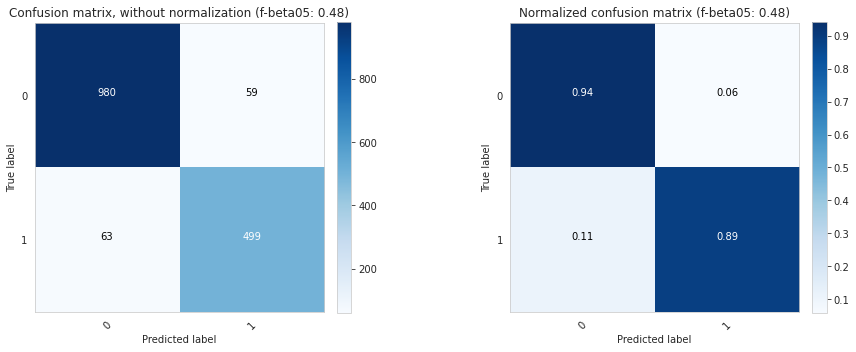

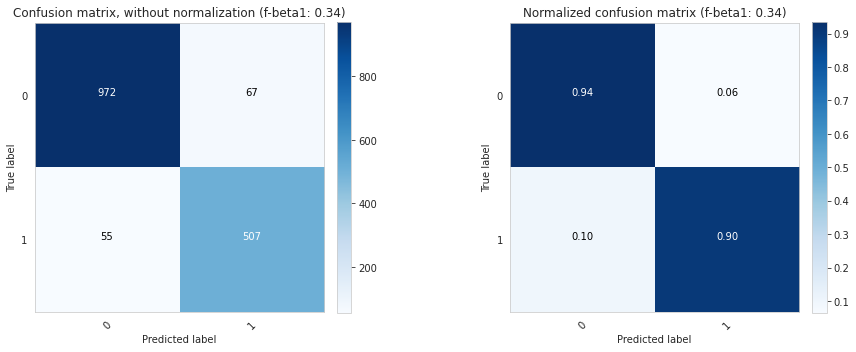

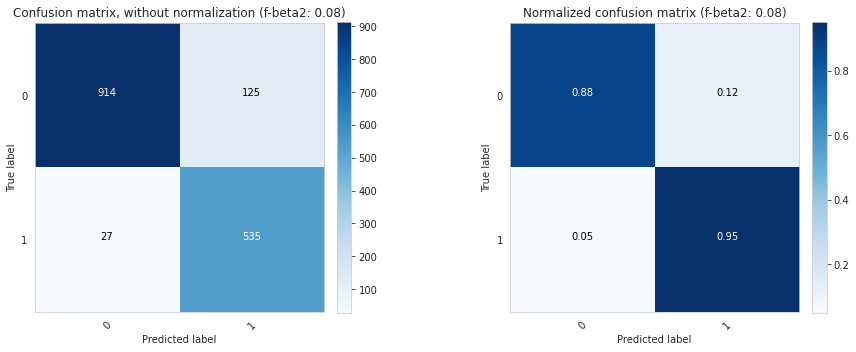



ROC Curve:


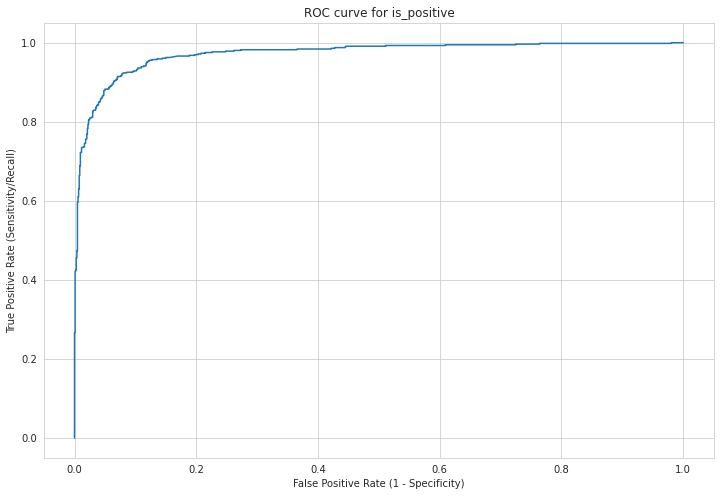

Predicted Probability Distribution:


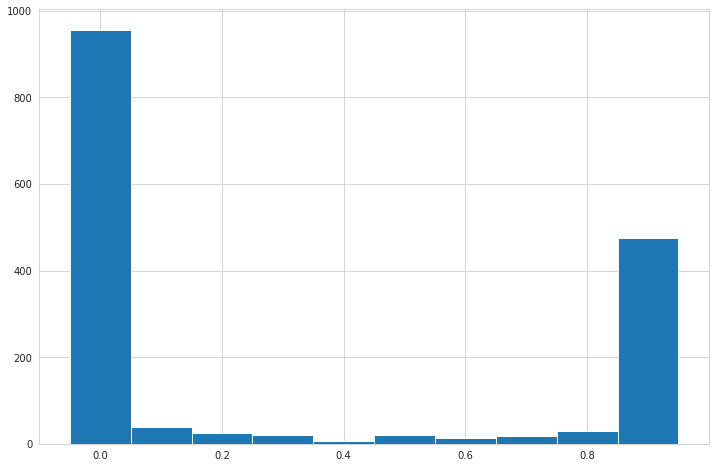



----------------------------------------------------------------------------------------------------


IS_VERY_NEGATIVE

Null Accuracy:	0.9256714553404123
AUC Score:	0.9421460892049128

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9400374765771393	0.9356652092442224	0.8675827607745159	
Cohen's Kappa:	0.4650181696670983	0.5269930326681525	0.44013037869865435	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9529              0.9838              0.9681              1482                
1                   0.662               0.395               0.4947              119                 
avg/total           0.8075              0.6894              0.7314              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9643              0.9663              0.9653         

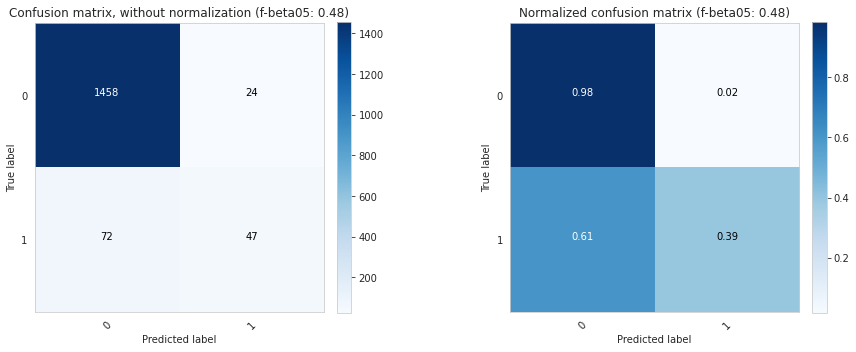

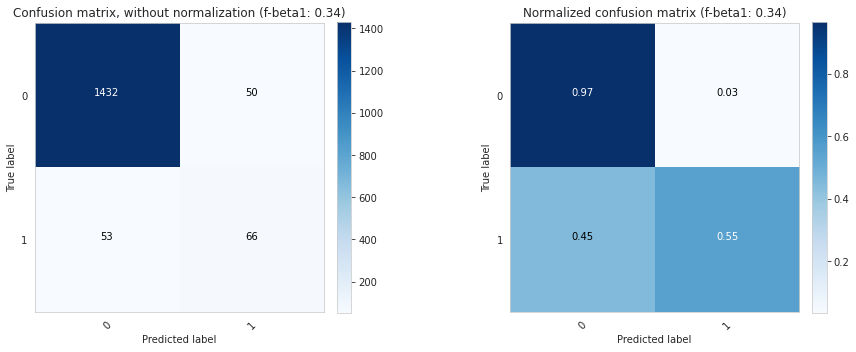

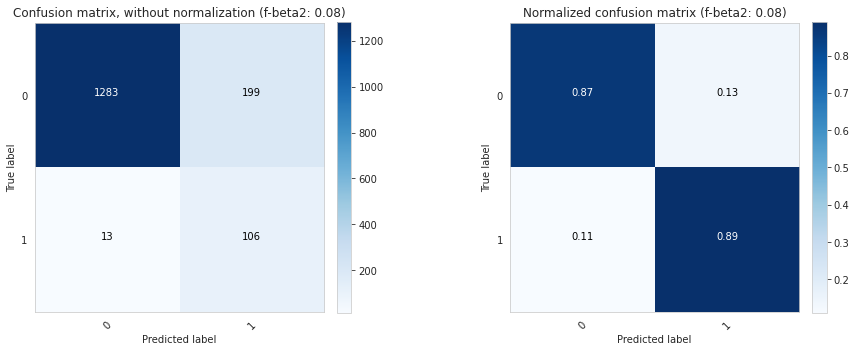



ROC Curve:


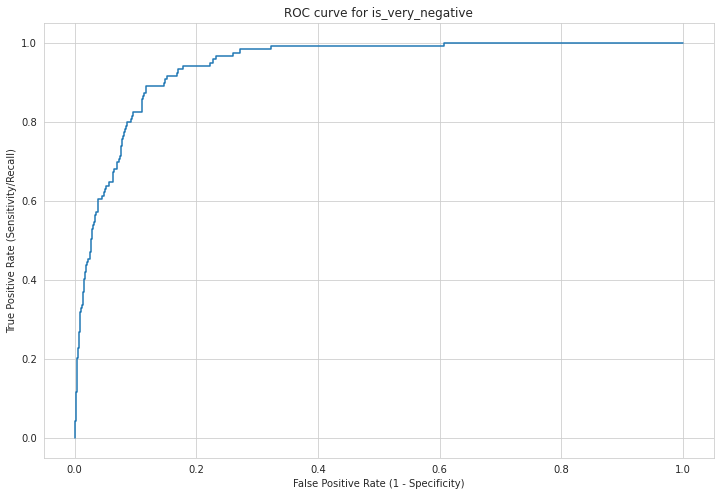

Predicted Probability Distribution:


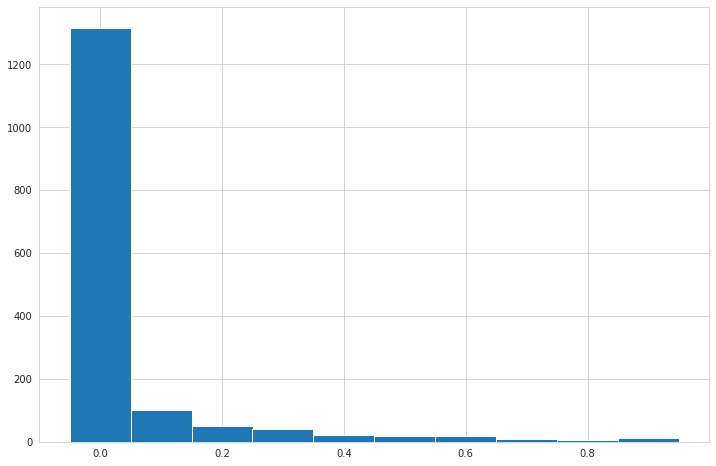



----------------------------------------------------------------------------------------------------


IS_NEGATIVE

Null Accuracy:	0.6327295440349782
AUC Score:	0.9474232931079637

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.8900687070580887	0.8856964397251718	0.8107432854465959	
Cohen's Kappa:	0.763638102300237	0.7584567707341444	0.6269910412275771	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9139              0.9121              0.913               1013                
1                   0.8492              0.852               0.8506              588                 
avg/total           0.8815              0.8821              0.8818              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9314              0.8845              0.9073              10

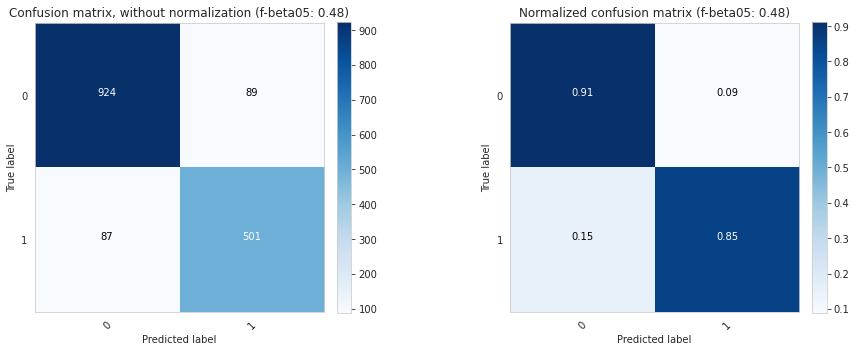

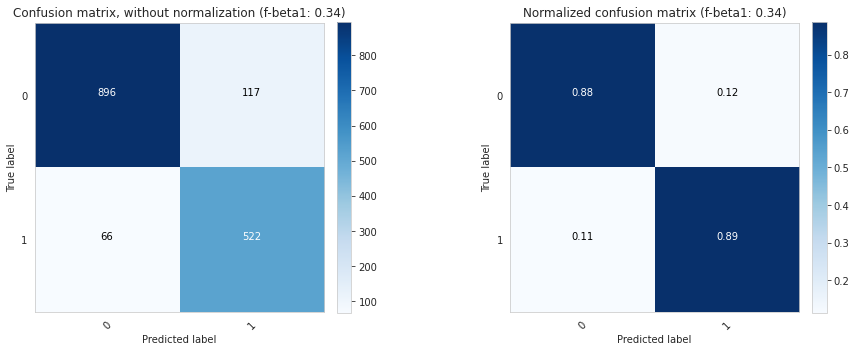

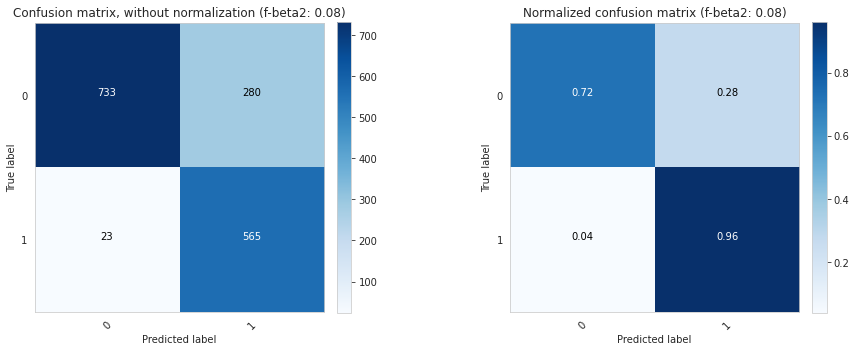



ROC Curve:


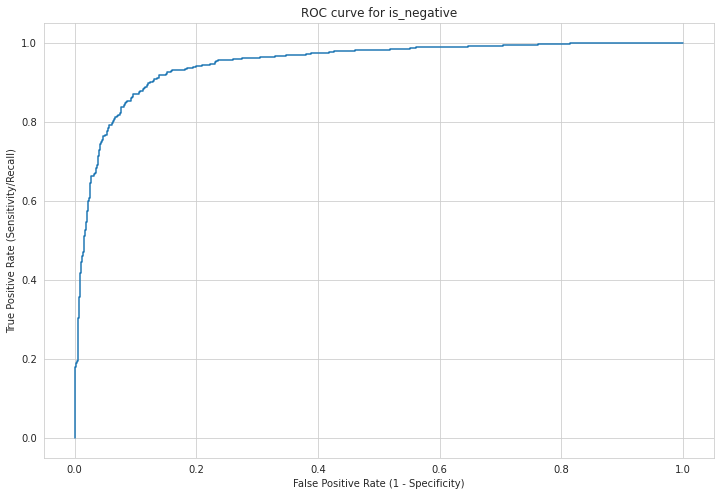

Predicted Probability Distribution:


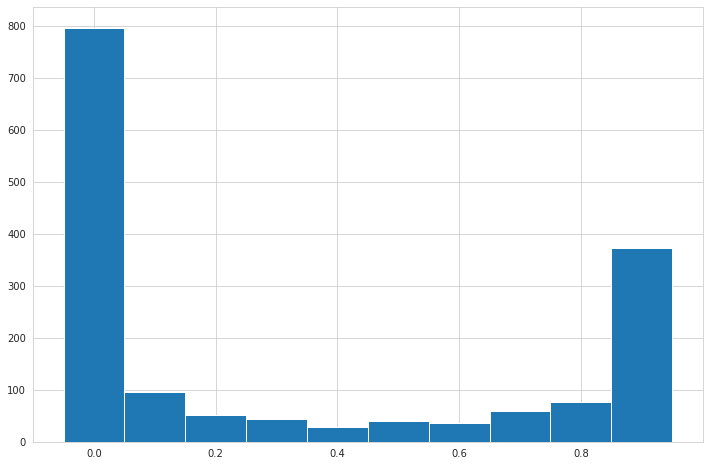



----------------------------------------------------------------------------------------------------


IS_SUGGESTION

Null Accuracy:	0.7089319175515303
AUC Score:	0.9516004613261235

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.905683947532792	0.9038101186758276	0.8844472204871955	
Cohen's Kappa:	0.7665917124228694	0.7663314201663469	0.7365021693855528	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9212              0.948               0.9344              1135                
1                   0.8637              0.8026              0.832               466                 
avg/total           0.8925              0.8753              0.8832              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9306              0.9339              0.9323              

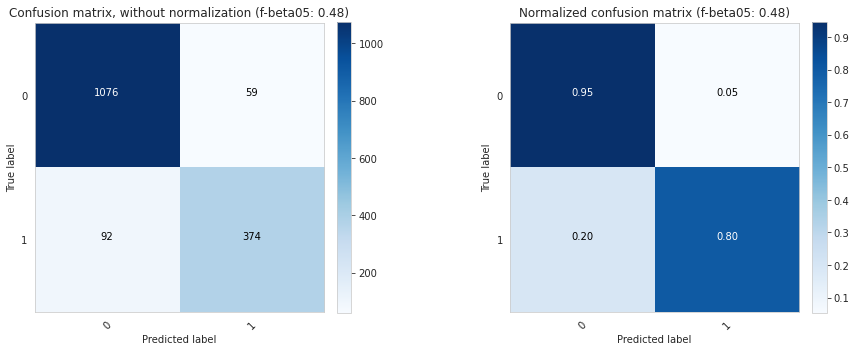

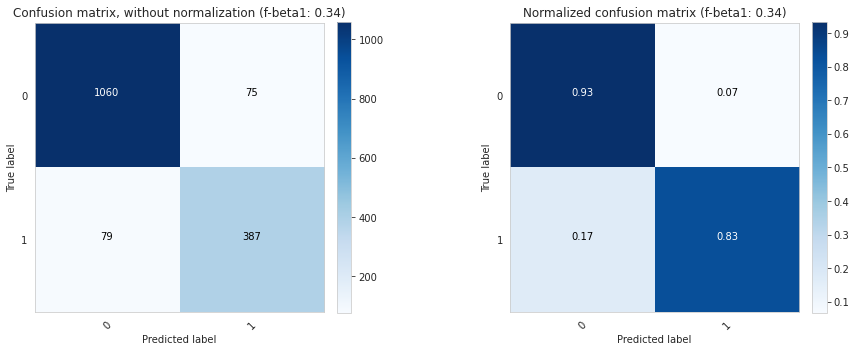

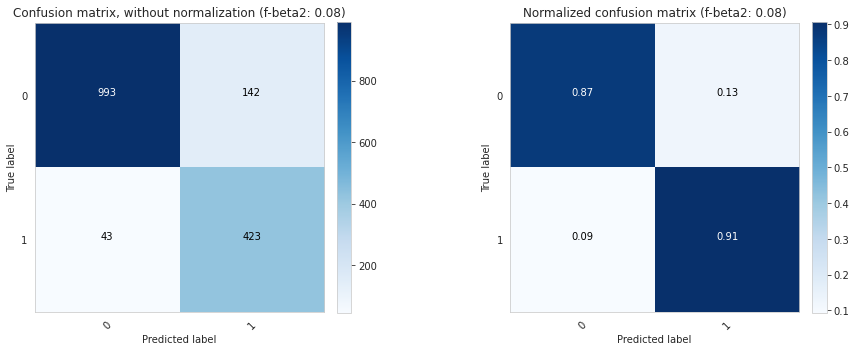



ROC Curve:


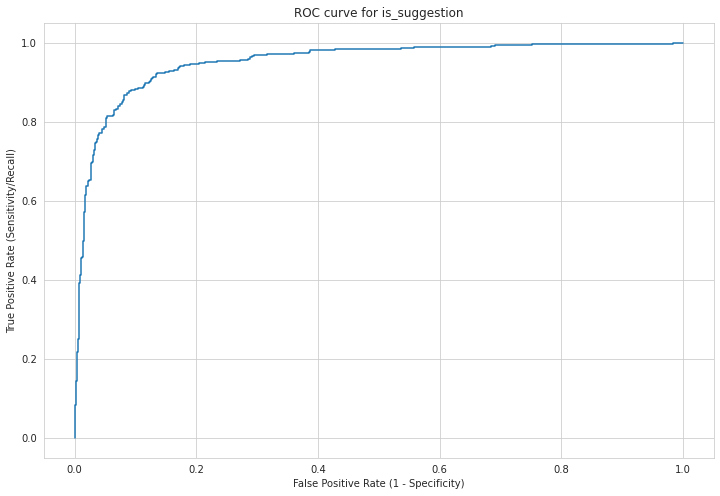

Predicted Probability Distribution:


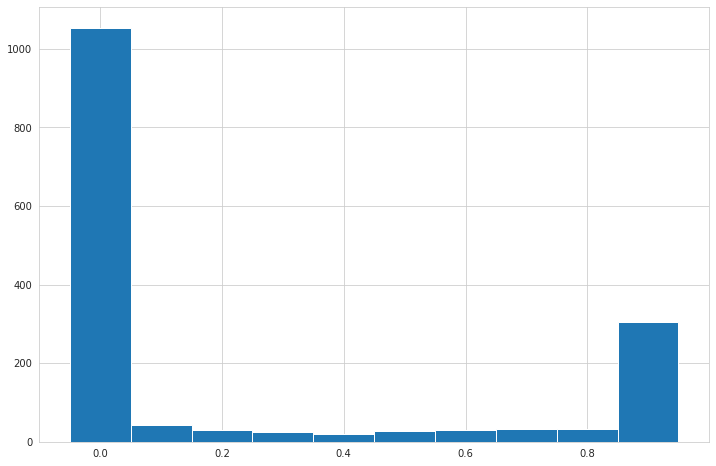



----------------------------------------------------------------------------------------------------


FEELS_THREATENED

Null Accuracy:	0.9731417863835103
AUC Score:	0.9940890228975728

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9862585883822611	0.985633978763273	0.976889444097439	
Cohen's Kappa:	0.7538265841009799	0.7555773864443456	0.6612957636955167	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9948              0.991               0.9929              1558                
1                   0.7143              0.814               0.7609              43                  
avg/total           0.8546              0.9025              0.8769              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9961              0.9891              0.9926            

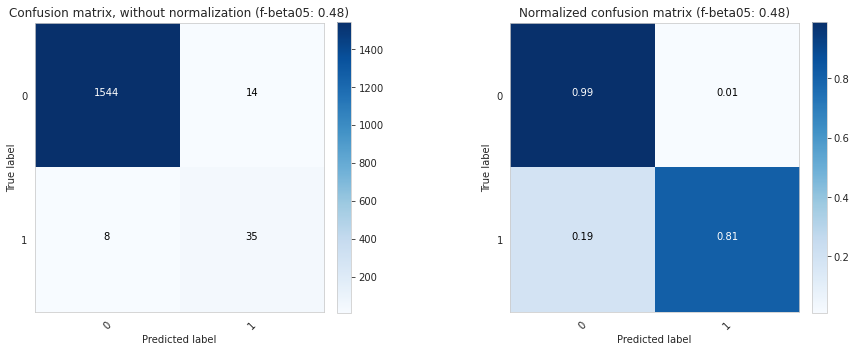

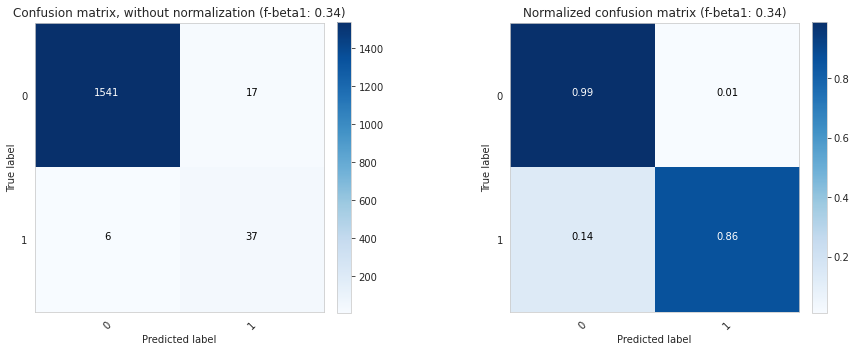

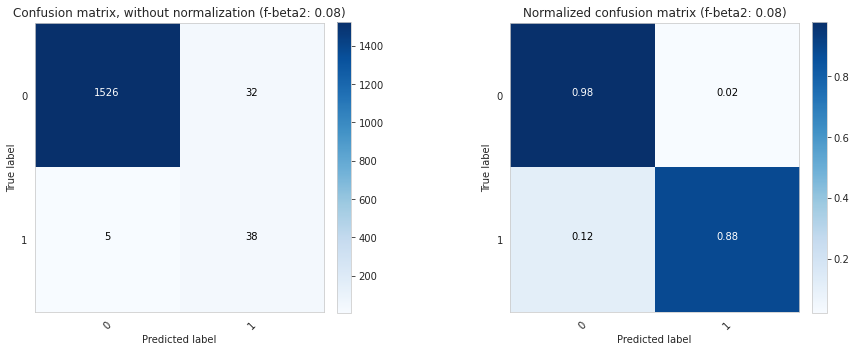



ROC Curve:


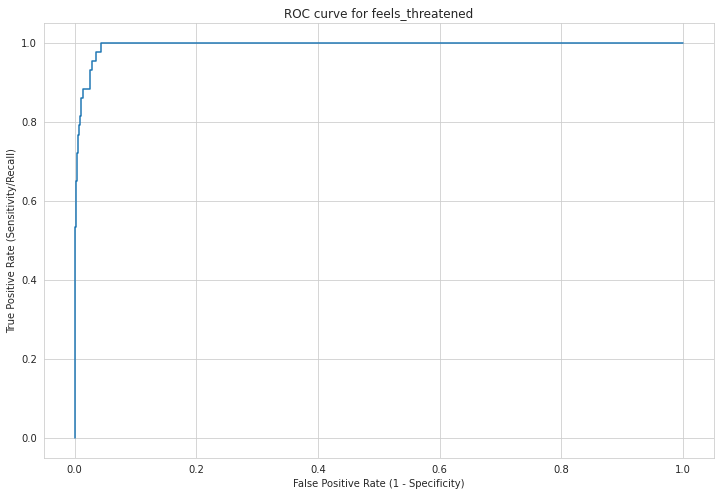

Predicted Probability Distribution:


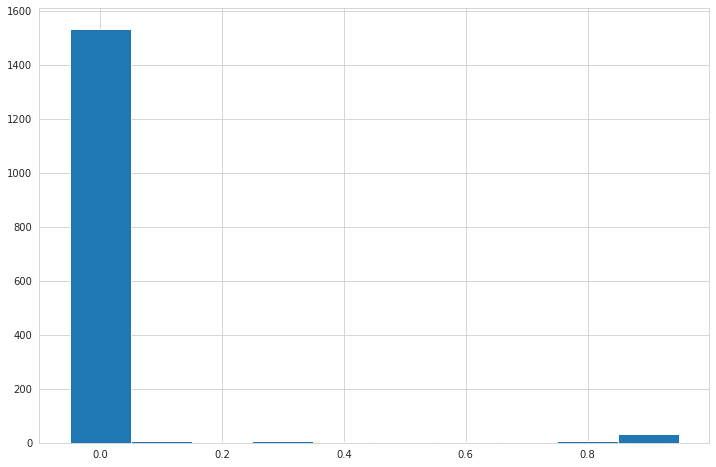



----------------------------------------------------------------------------------------------------


HAS_PROFANITY

Null Accuracy:	0.9831355402873204
AUC Score:	0.9857640359546331

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9893816364772018	0.9912554653341662	0.9906308557151781	
Cohen's Kappa:	0.5805347923248825	0.6776170065874636	0.6891704741072469	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9905              0.9987              0.9946              1574                
1                   0.8571              0.4444              0.5854              27                  
avg/total           0.9238              0.7216              0.79                1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9924              0.9987              0.9956             

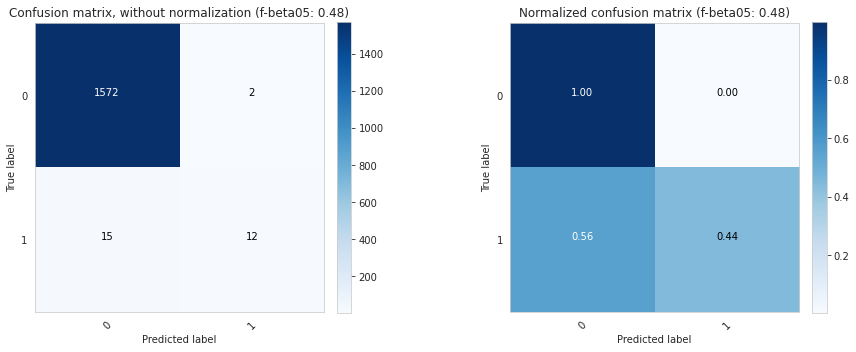

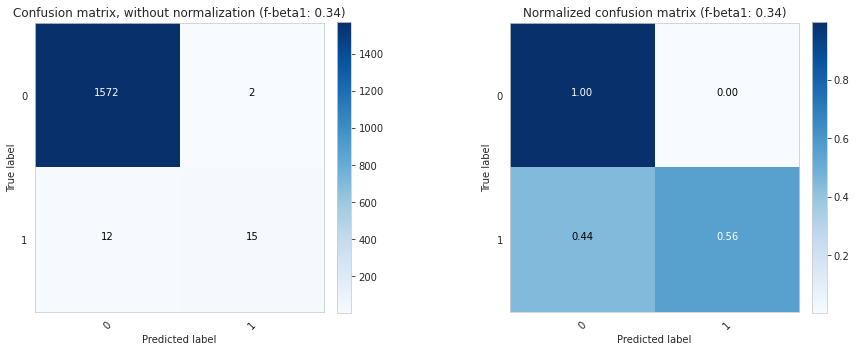

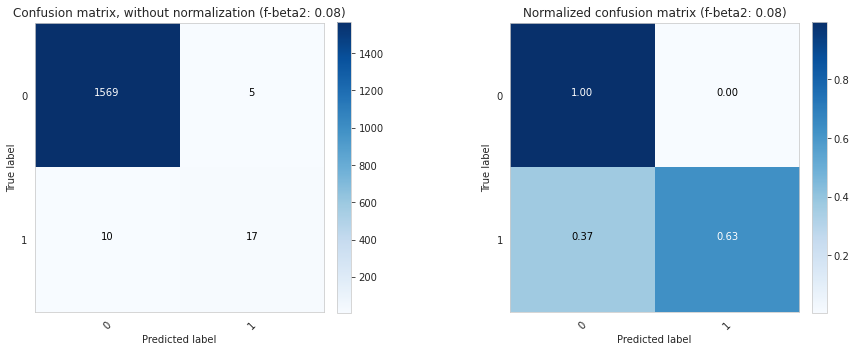



ROC Curve:


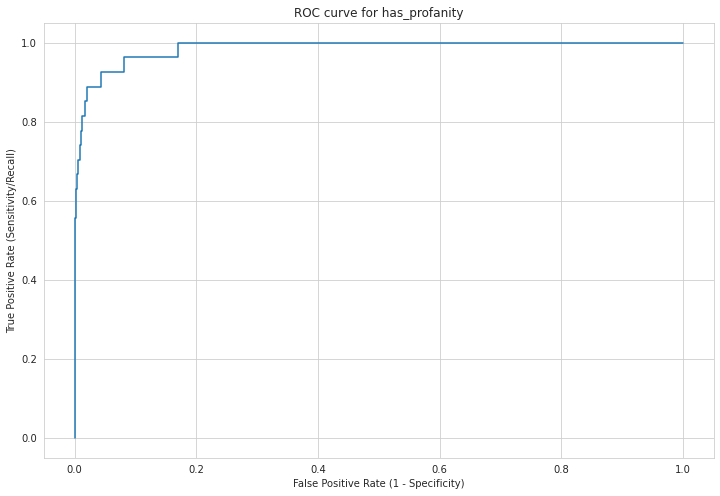

Predicted Probability Distribution:


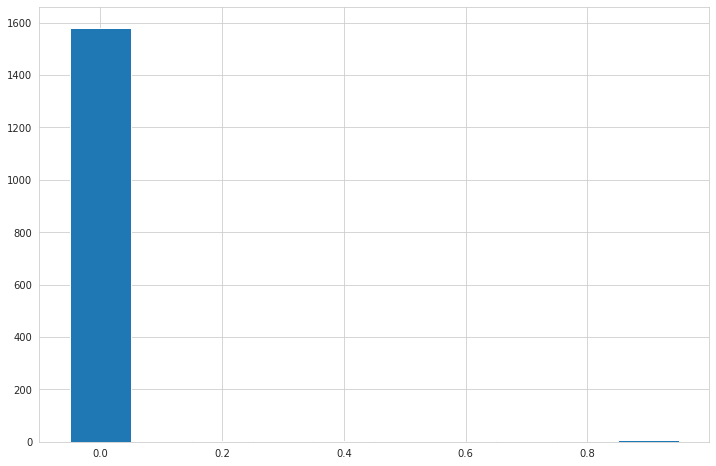



----------------------------------------------------------------------------------------------------


IS_NONSENSE

Null Accuracy:	0.9169269206745784
AUC Score:	0.9505106430927455

		f-beta05(0.48)		f-beta1(0.34)		f-beta2(0.08)
Accuracy:	0.9612742036227357	0.962523422860712	0.948157401623985	
Cohen's Kappa:	0.733021694576087	0.7488482997714901	0.6979128540998403	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9744              0.9837              0.979               1468                
1                   0.7983              0.7143              0.754               133                 
avg/total           0.8863              0.849               0.8665              1601                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9776              0.9816              0.9796              1468

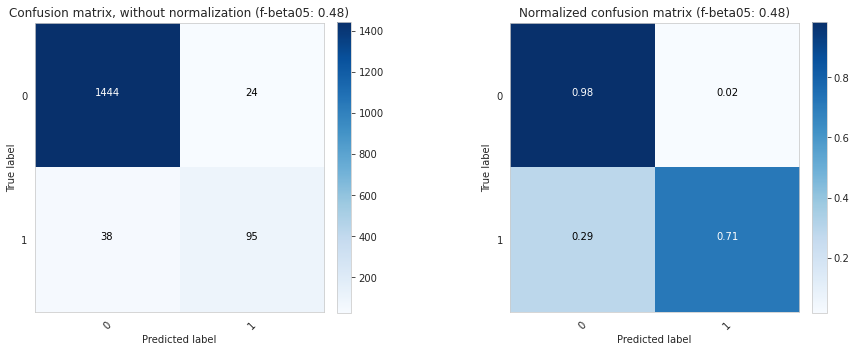

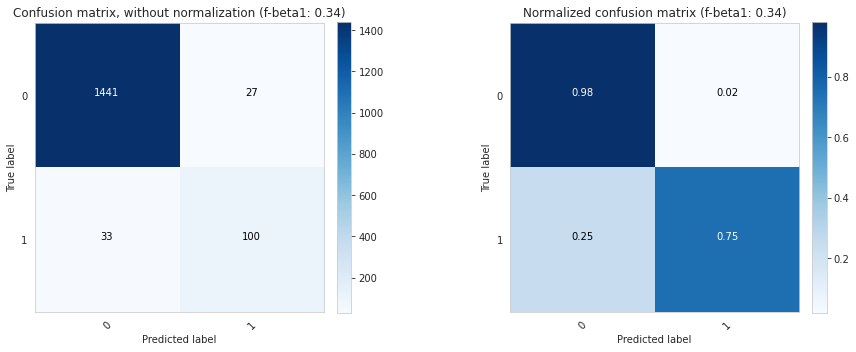

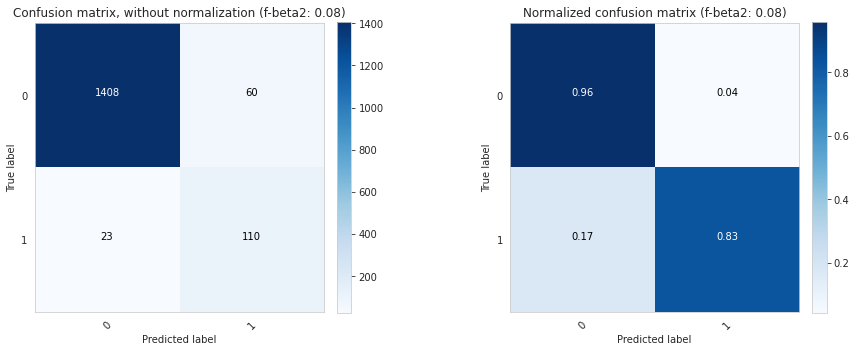



ROC Curve:


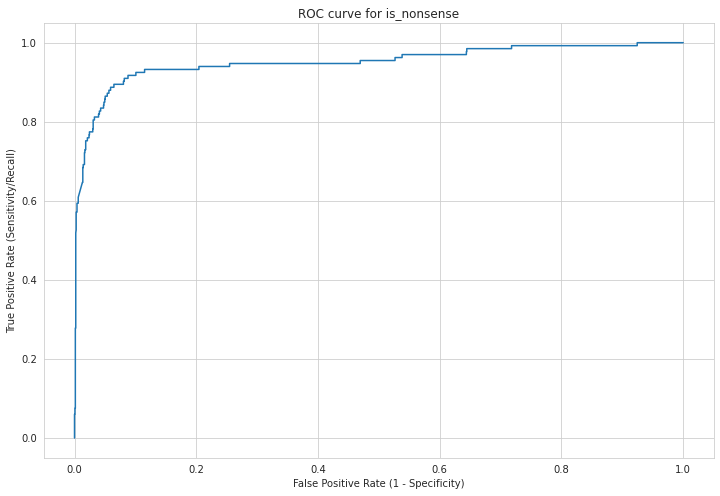

Predicted Probability Distribution:


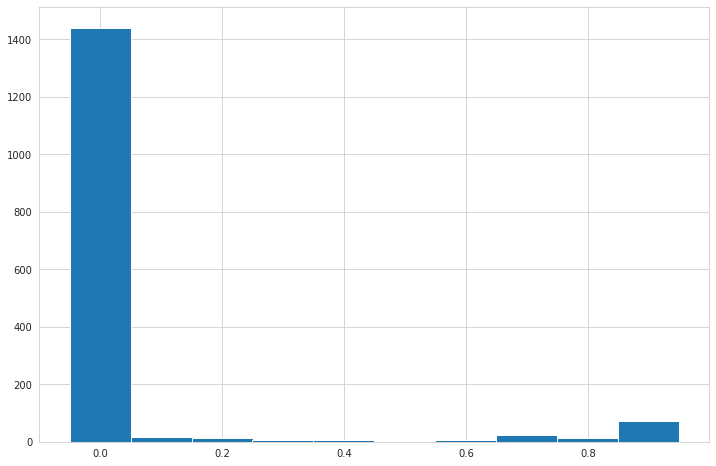



----------------------------------------------------------------------------------------------------




In [258]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multilabel'

dls = torch.load(SENTIMENT_CLS_PATH/f'data_cls_sentiment.pkl')

learn_fwd = load_learner(fname=SENTIMENT_CLS_PATH/f'fwd_export_clas{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=SENTIMENT_CLS_PATH/f'bwd_export_clas{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final = (probs_fwd + probs_bwd) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_fwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_fwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_fwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_fwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_bwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_bwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_bwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_bwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_final, lbl_fwd)
threshold_f1 = f1.opt_th(probs_final, lbl_fwd)
threshold_f2 = f2.opt_th(probs_final, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_final, lbl_fwd, sigmoid=False)}')

In [ ]:
final_valid_loss = (loss_fwd.mean() + loss_bwd.mean()) / 2; final_valid_loss.item()

### Metrics

### Inference (ad-hoc documents)

In [ ]:
print(SENT_LABELS[1:])

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 130].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
verbatims_df.head()

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_sentiment_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=SENTIMENT_CLS_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_sentiment_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_sentiment_results(backwards=True)

probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in SENT_LABELS[1:]]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in SENT_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
import datetime
final_df.to_csv(SENTIMENT_CLS_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

In [ ]:
%time 

np.save(str(SENTIMENT_CLS_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(SENTIMENT_CLS_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(SENTIMENT_CLS_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(SENTIMENT_CLS_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
type(threshold_f2), threshold_f2

In [ ]:
threat_df = final_df[final_df.prob_feels_threatened > threshold_f2]
# threat_df = final_df[(final_df.FeelsThreatened == 1) & (pd.notna(final_df.LastTaggedOn))]
threat_df

In [ ]:
threat_df.AnswerText[threat_df.Id == 311022].values

In [ ]:
len(learn.opt.param_groups)

In [ ]:
[ print(f'{lg}\n') for lg in learn.opt.param_groups ]